### Modelling the Galactic LMXB distribution

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import astropy.units as u
%matplotlib notebook

We follow https://ui.adsabs.harvard.edu/abs/2019MNRAS.484...19J and use https://ui.adsabs.harvard.edu/abs/2002A%26A...391..923G/abstract to construct a function which provides probabilistic samples of LMXB positions and distances.  Grimm+02 has a typo for the disk distribution; we use the correct version from https://ui.adsabs.harvard.edu/abs/1998MNRAS.294..429D/abstract.

In [44]:
density_convert = (1*u.parsec**-3).to(u.kpc**-3.)

In [156]:
def rho_bulge(r, z, rho0_bulge=1.9789*1e9, r0=1.0, q=0.6, gamma=1.8, rt=1.9):
    """Bulge density model from Grimm et al. 2002 (Eqn. 4)
    
    Parameters
    ----------
    r : float
        distance from the Galactic center (kpc)
    z : float
        distance perpendicular to the Galactic Plane (kpc)
    
    Returns
    -------
    density in solar masses per cubic kpc
    
    """
    
    return rho0_bulge * (np.sqrt(r**2. + z**2./q**2.)/r0)**(-1.*gamma) * np.exp(-1. * (r**2. + z**2./q**2.)/rt**2.)

def rho_disk(r, z, rho0_disk=1.313415*1e9, rm=6.5, rd=3.5, rz=0.410):
    """Disk density model from Grimm et al. 2002 (Eqn. 5).  
    
    Note a typo in the Grimm+02 paper; we include the correct version from Dehnen & Binney (1998)
    
    Parameters
    ----------
    r : float
        distance from the Galactic center (kpc)
    z : float
        distance perpendicular to the Galactic Plane (kpc)
    
    Returns
    -------
    density in solar masses per cubic kpc
    
    """
    
    return rho0_disk * np.exp(-1.*rm/rd - r/rd - np.abs(z)/rz)

def mass_disk(rho0_disk=1.313415*1e9, rm=6.5, rd=3.5, rz=0.410):
    """Integrated mass of disk from Dehnen & Binney (1998) eqn. 2
    
    Parameters
    ----------
    
    Returns
    -------
    density in solar masses
    
    """
    from scipy.special import kn
    
    sigma_d = rho0_disk * 2 * rz
    
    return 4*np.pi*sigma_d*rm*rd* kn(2,2*np.sqrt(rm/rd))

def rho_sphere(r, z, rho0_sphere=8.74*1e9, b=7.669, Re=2.8):
    """Disk density model from Grimm et al. 2002 (Eqn. 6)
    
    Parameters
    ----------
    r : float
        distance from the Galactic center (kpc)
    z : float
        distance perpendicular to the Galactic Plane (kpc)
    
    Returns
    -------
    density in solar masses per cubic kpc
    
    """
    
    R = np.sqrt(r**2. + z**2.)
    
    return rho0_sphere * np.exp(-1.*b*(R/Re)**(1/4)) / (R/Re)**(7/8)

Integrate numerically to get total masses.  Integrate in Galactocentric cylindrical coordinates from r ∊ 0,15 kpc, z ∊ -15,15 kpc

In [157]:
bulge_mass = 2*np.pi*integrate.dblquad(lambda r,z: r * rho_bulge(r,z), -15, 15, lambda r: 0, lambda r: 15)[0] 
disk_mass = 2*np.pi*integrate.dblquad(lambda r,z: r * rho_disk(r,z), -15, 15, lambda r: 0, lambda r: 15)[0]  
sphere_mass = 2*np.pi*integrate.dblquad(lambda r, z: r * rho_sphere(r,z), -15, 15, lambda r: 0, lambda r: 15)[0]  

Compare our numerical integral to the analytic value... not perfect

In [158]:
mass_disk()/disk_mass

2.2802363085057036

MJ reports that they could not reproduce the Grimm mass ratios with the provided normalizations.  We will follow them and use the [Picaurd & Robin 04](https://ui.adsabs.harvard.edu/abs/2004A%26A...428..891P/abstract) bulge mass estimate of 2.4e10 Msun, and adjust the other normalizations to match ratios of 2:1:0.3.

In [159]:
print(f'{bulge_mass:.2e} {disk_mass:.2e} {sphere_mass:.2e}')

2.40e+10 1.20e+10 3.60e+09


In [160]:
bulge_mass/disk_mass

1.9999954308634986

In [163]:
sphere_mass/disk_mass

0.2998325450823631

## Convert to relative spatial density in l, b for the TVS Plane metric

## testing rejection sampling

In [4]:
# rejection sampling test: from https://towardsdatascience.com/what-is-rejection-sampling-1f6aff92330d
import scipy.stats

casella_fn = lambda x: np.exp(-x**2./2) * (np.sin(6+x)**2. + 3*np.cos(x)**2. *np.sin(4*x)**2. + 1)


def sampler (use_gauss_proposal, c, N=1_000_000):
    prop_norm = scipy.stats.norm(loc=0, scale=1)
    prop_uni = scipy.stats.uniform(-3, 6)

    if use_gauss_proposal:
        X = np.random.randn(N)
        u= np.random.uniform(0, c * prop_norm.pdf(X))
    else:
        X = np.random.uniform(-3,3, size=N)
        u= np.random.uniform(0, c * prop_uni.pdf(X))

    casella_samples = X[u <= casella_fn(X)]

    print ("Accepted -", len(casella_samples)/N)

    return casella_samples

samples_using_uniform_prop = sampler(False, 25)
samples_using_gauss_prop = sampler(True, 11)

Accepted - 0.229684
Accepted - 0.523055


<IPython.core.display.Javascript object>


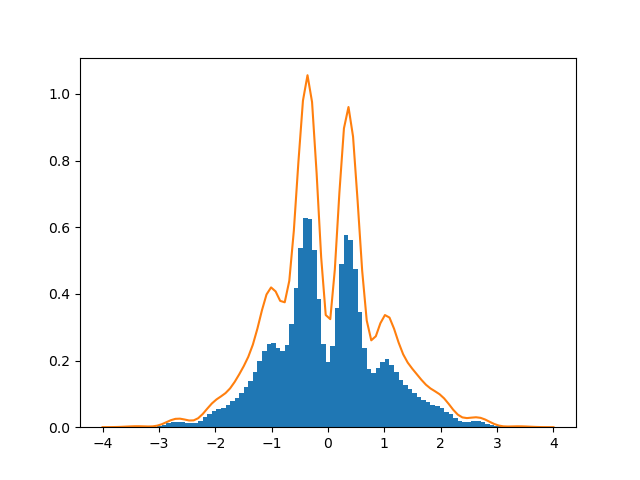

In [12]:
t = np.linspace(-4,4,100)
plt.hist(samples_using_gauss_prop,bins=t,density=True)
plt.plot(t,casella_fn(t)/3.5)
